# Introduction
1. <a href='#Key-points'>Key points</a>
2. <a href='#Data-Preparation'>Data Preparation</a>
2. <a href='#Matching-Implementation'>Matching implementation</a>
3. <a href='#Matching-Review'>Matching Review</a>
4. <a href='#Average-Treatement-effect'>Average Treatement Effect</a>
1. <a href='#References'>References</a>

# Key points
- Conditional Indipendence Assumption: There are no unobserved differences correlated to potential outcomes once we have controlled for certain observable characteristics
- Participation can be considered random among observations with the same characteristics
- Identification condition: observations with similar characteristics X present in both treatment and control groups. This requires 0 < P(T=1|X) < 1
- Selection on treatment (or not) should be solely based on observable characteristics (i.e. X). Assuming there is no selection bias from unobserved characteristics. It is not possible to prove the validity of this unconfoundedness assumption.
- There is a cost in not doing RCT (randomised controlled testing)
- Curse of dimensionality -> propensity score matching
- Prop. score: propability of participating in the treatment based on observable characteristics (i.e. X)

# Data Preparation

In [1]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [2]:
from functions import *
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})


Bad key "text.kerning_factor" on line 4 in
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
df = pd.read_csv('train.csv')
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

First view of usual Titanic dataset:

In [4]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Create an artificial treatment effect. It is based on the condition that a passenger has a cabin (1) or not (0).

In [5]:
df['treatment'] = df.Cabin.apply(hasCabin)

There is high correlation between treatment (i.e. hasCabin) and Class.
This is desirable in this case as it plays the role of the systematic factor affecting the treatment.
In a different context this could be a landing page on site that only specific visitors see.

In [77]:
pd.pivot_table(df[['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1,2,3
treatment,,,
0,26,158,345
1,158,15,10


Keeping only specific variables
We should account for all variables that affect the treatment variable (i.e. hasCabin)

In [7]:
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]

In [8]:
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

In [9]:
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=False)

In [10]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [11]:
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)

In [12]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))

Accuracy: 0.9284

Confusion matrix:
[[503  26]
 [ 25 158]]

F1 score is: 0.8610


Convert propability to logit (based on the suggestion at https://youtu.be/gaUgW7NWai8?t=981)

In [13]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

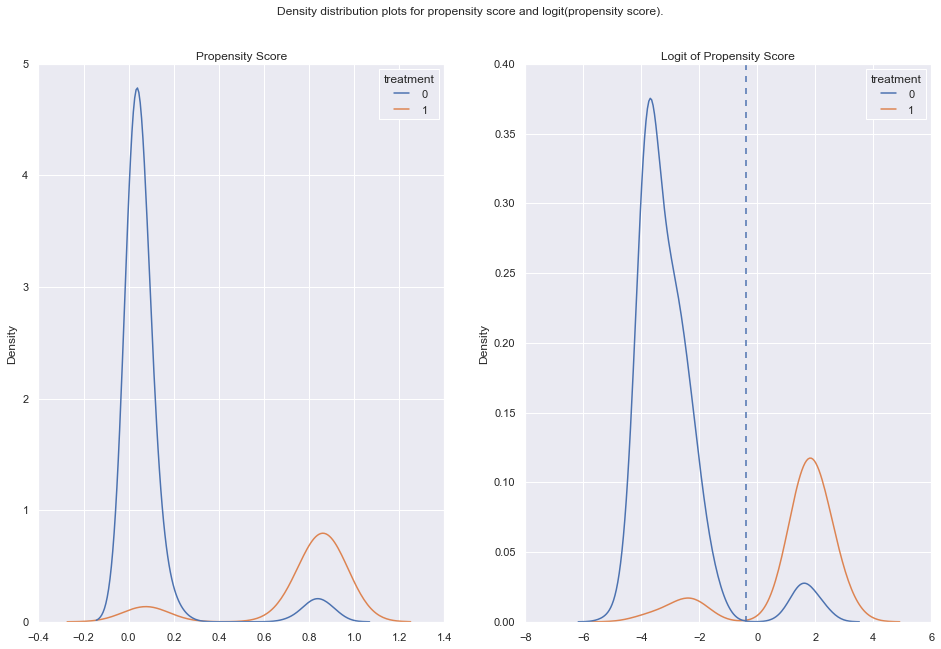

In [14]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

The graph on the right (logit_propensity_score) demonstrates the density for each treatment status. There is overlap accross the range of values (-6,5). However on the left of "-0.4" there are a lot more 0's than 1's. On the right side of "-0.4", the opposite is true (a lot more 1's than 0's). This will affect later how we will perform the matching so we can have balanced groups.

In [15]:
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [16]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Survived

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Survived
X_encoded.loc[:,'treatment'] = df_data.treatment

/Users/konos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
X_encoded.loc[0]

Age                       22.000000
SibSp                      1.000000
Parch                      0.000000
Fare                       7.250000
sex_female                 0.000000
sex_male                   1.000000
embarked_C                 0.000000
embarked_Q                 0.000000
embarked_S                 1.000000
class_1                    0.000000
class_2                    0.000000
class_3                    1.000000
propensity_score           0.021156
propensity_score_logit    -3.834463
outcome                    0.000000
treatment                  0.000000
Name: 0, dtype: float64

Within the common support area, there are 25 treated samples. There are 152 untreated samples that we can use as a pool for the matching.

In [18]:
df_data.treatment.value_counts()

0    529
1    183
Name: treatment, dtype: int64

## Matching Implementation
Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).
- Caliper: 25% of standart deviation of logit(propensity score)

In [19]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_encoded.loc[common_support].reset_index().rename(columns = {'index':'old_index'})

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0889



NearestNeighbors(n_neighbors=10, radius=0.08890268148266278)

For each data point (based on the logit propensity score) obtain (at most) 10 nearest matches. This is regardless of their treatment status.

In [20]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [21]:
print('For item 0, the closest distances are (first item is self):')
for ds in distances[0,:]:
    print('Element distance: {:4f}'.format(ds))

For item 0, the closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000021
Element distance: 0.001106
Element distance: 0.004490
Element distance: 0.006540
Element distance: 0.006749
Element distance: 0.007118
Element distance: 0.008545
Element distance: 0.009793
Element distance: 0.010411


In [22]:
print('For item 0, the closest indexes are (first item is self):')
for idx in indexes[0,:]:
    print('Element index: {}'.format(idx))

For item 0, the closest indexes are (first item is self):
Element index: 0
Element index: 607
Element index: 539
Element index: 301
Element index: 590
Element index: 641
Element index: 611
Element index: 36
Element index: 134
Element index: 449


The overall space is split in two cases:
1. propensity_score_logit is greater than 0.4 - Less items with T=1 are present. This is used as the starting pool and select the closest item with T=0.
2. propensity_score_logit is less than 0.4 - Less items with T=0 are present. This is used as the starting pool and select the closest item with T=1.

In [23]:
def perfom_matching(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (prop_score_logit < -0.4) and (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
        elif (prop_score_logit > -0.4) and (current_index != idx) and (row.treatment == 0) and (df_data.loc[idx].treatment == 1):
            return int(idx)
        
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching, axis = 1, args = (indexes, df_data))

In [24]:
treated_with_match = ~df_data.matched_element.isna()
untreated_with_match = df_data.reset_index()['index'].isin(df_data.matched_element)

In [25]:
all_matched_elements = pd.DataFrame(data = {'a' : treated_with_match, 'b' :untreated_with_match}).any(axis = 1)

In [26]:
matched_data = df_data.loc[all_matched_elements]

In [27]:
matched_data[['propensity_score','propensity_score_logit','outcome','treatment','matched_element']].head(5)

,propensity_score,propensity_score_logit,outcome,treatment,matched_element
3,0.895107,2.144005,1,1,NaN
5,0.805110,1.418544,0,1,NaN
9,0.063216,-2.695902,1,1,686.0
18,0.059719,-2.756534,1,1,636.0
22,0.102161,-2.173435,1,0,NaN


Items that have matched_element = NaN, do not hold the matched-element information. This is held at their counterpart elements.

In [28]:
matched_data.treatment.value_counts()

0    51
1    50
Name: treatment, dtype: int64

In total 50 treated elements (i.e. hasCabin = True) have been matched with 51 untreated elements.

# Matching Review

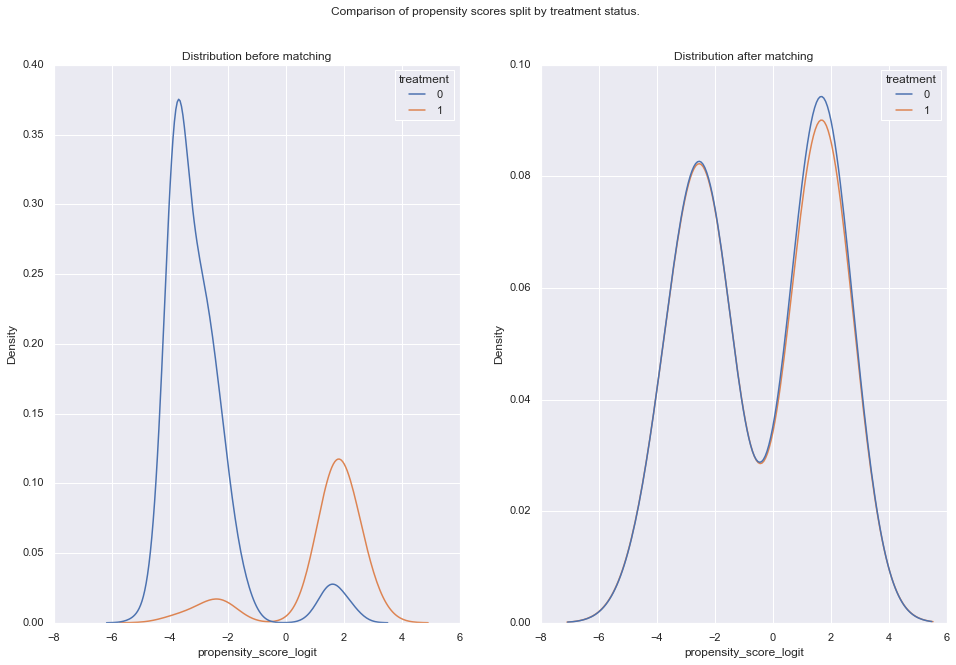

In [29]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Comparison of propensity scores split by treatment status.')
sns.kdeplot(data = df_data, x = 'propensity_score_logit', hue = 'treatment', ax = ax[0]).set(title='Distribution before matching')
sns.kdeplot(data = matched_data, x = 'propensity_score_logit', hue = 'treatment',  ax = ax[1]).set(title='Distribution after matching')
plt.show()

In [67]:
def obtain_matched_pairs(row):
    # import pdb;pdb.set_trace()
    x1 = row.Age
    y1 = row.Fare
   
    x2 = matched_data.loc[row.matched_element].Age
    y2 = matched_data.loc[row.matched_element].Fare
    return (x1, y1, x2, y2)
    
points = matched_data[~matched_data.matched_element.isna()].apply(obtain_matched_pairs, axis = 1)

In [78]:
matched_data[~matched_data.matched_element.isna()].head(2)

,old_index,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
9,10,4.0,1,1,16.7,1,0,0,0,1,0,0,1,0.063216,-2.695902,1,1,686.0
18,21,34.0,0,0,13.0,0,1,0,0,1,0,1,0,0.059719,-2.756534,1,1,636.0


In [84]:
matched_data.head().index

Int64Index([3, 5, 9, 18, 22], dtype='int64')

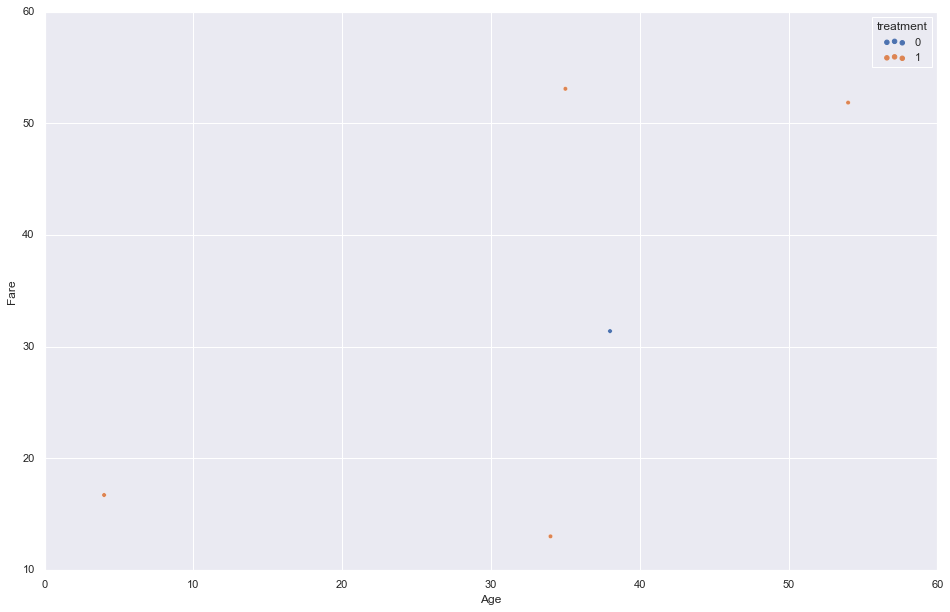

In [91]:
sns.scatterplot(data = matched_data.head(), x = 'Age', y = 'Fare', hue = 'treatment')
# for (x1, y1, x2, y2) in points[points]:
#    plt.plot([x1, y1], [x2, y2], linewidth=0.2)

In [31]:
data = []
cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S','class_1','class_2','class_3']
# cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(matched_data,cl)])

In [32]:
res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

[Text(0.5, 1.0, 'Mean differences between treatment groups before and after matching.')]

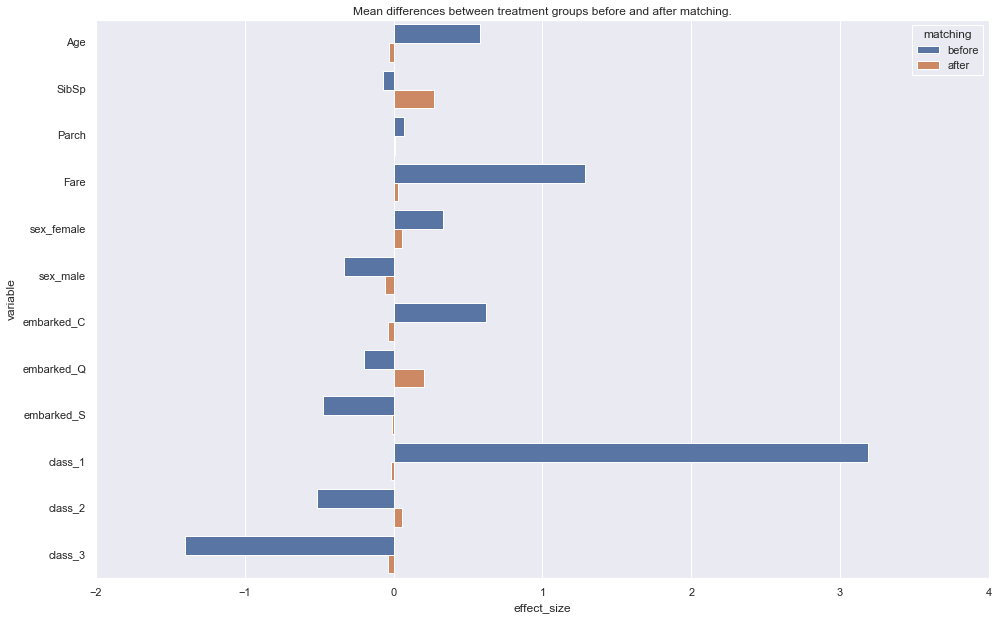

In [33]:
sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h').\
    set(title='Mean differences between treatment groups before and after matching.')

In [34]:
cols.append('treatment')

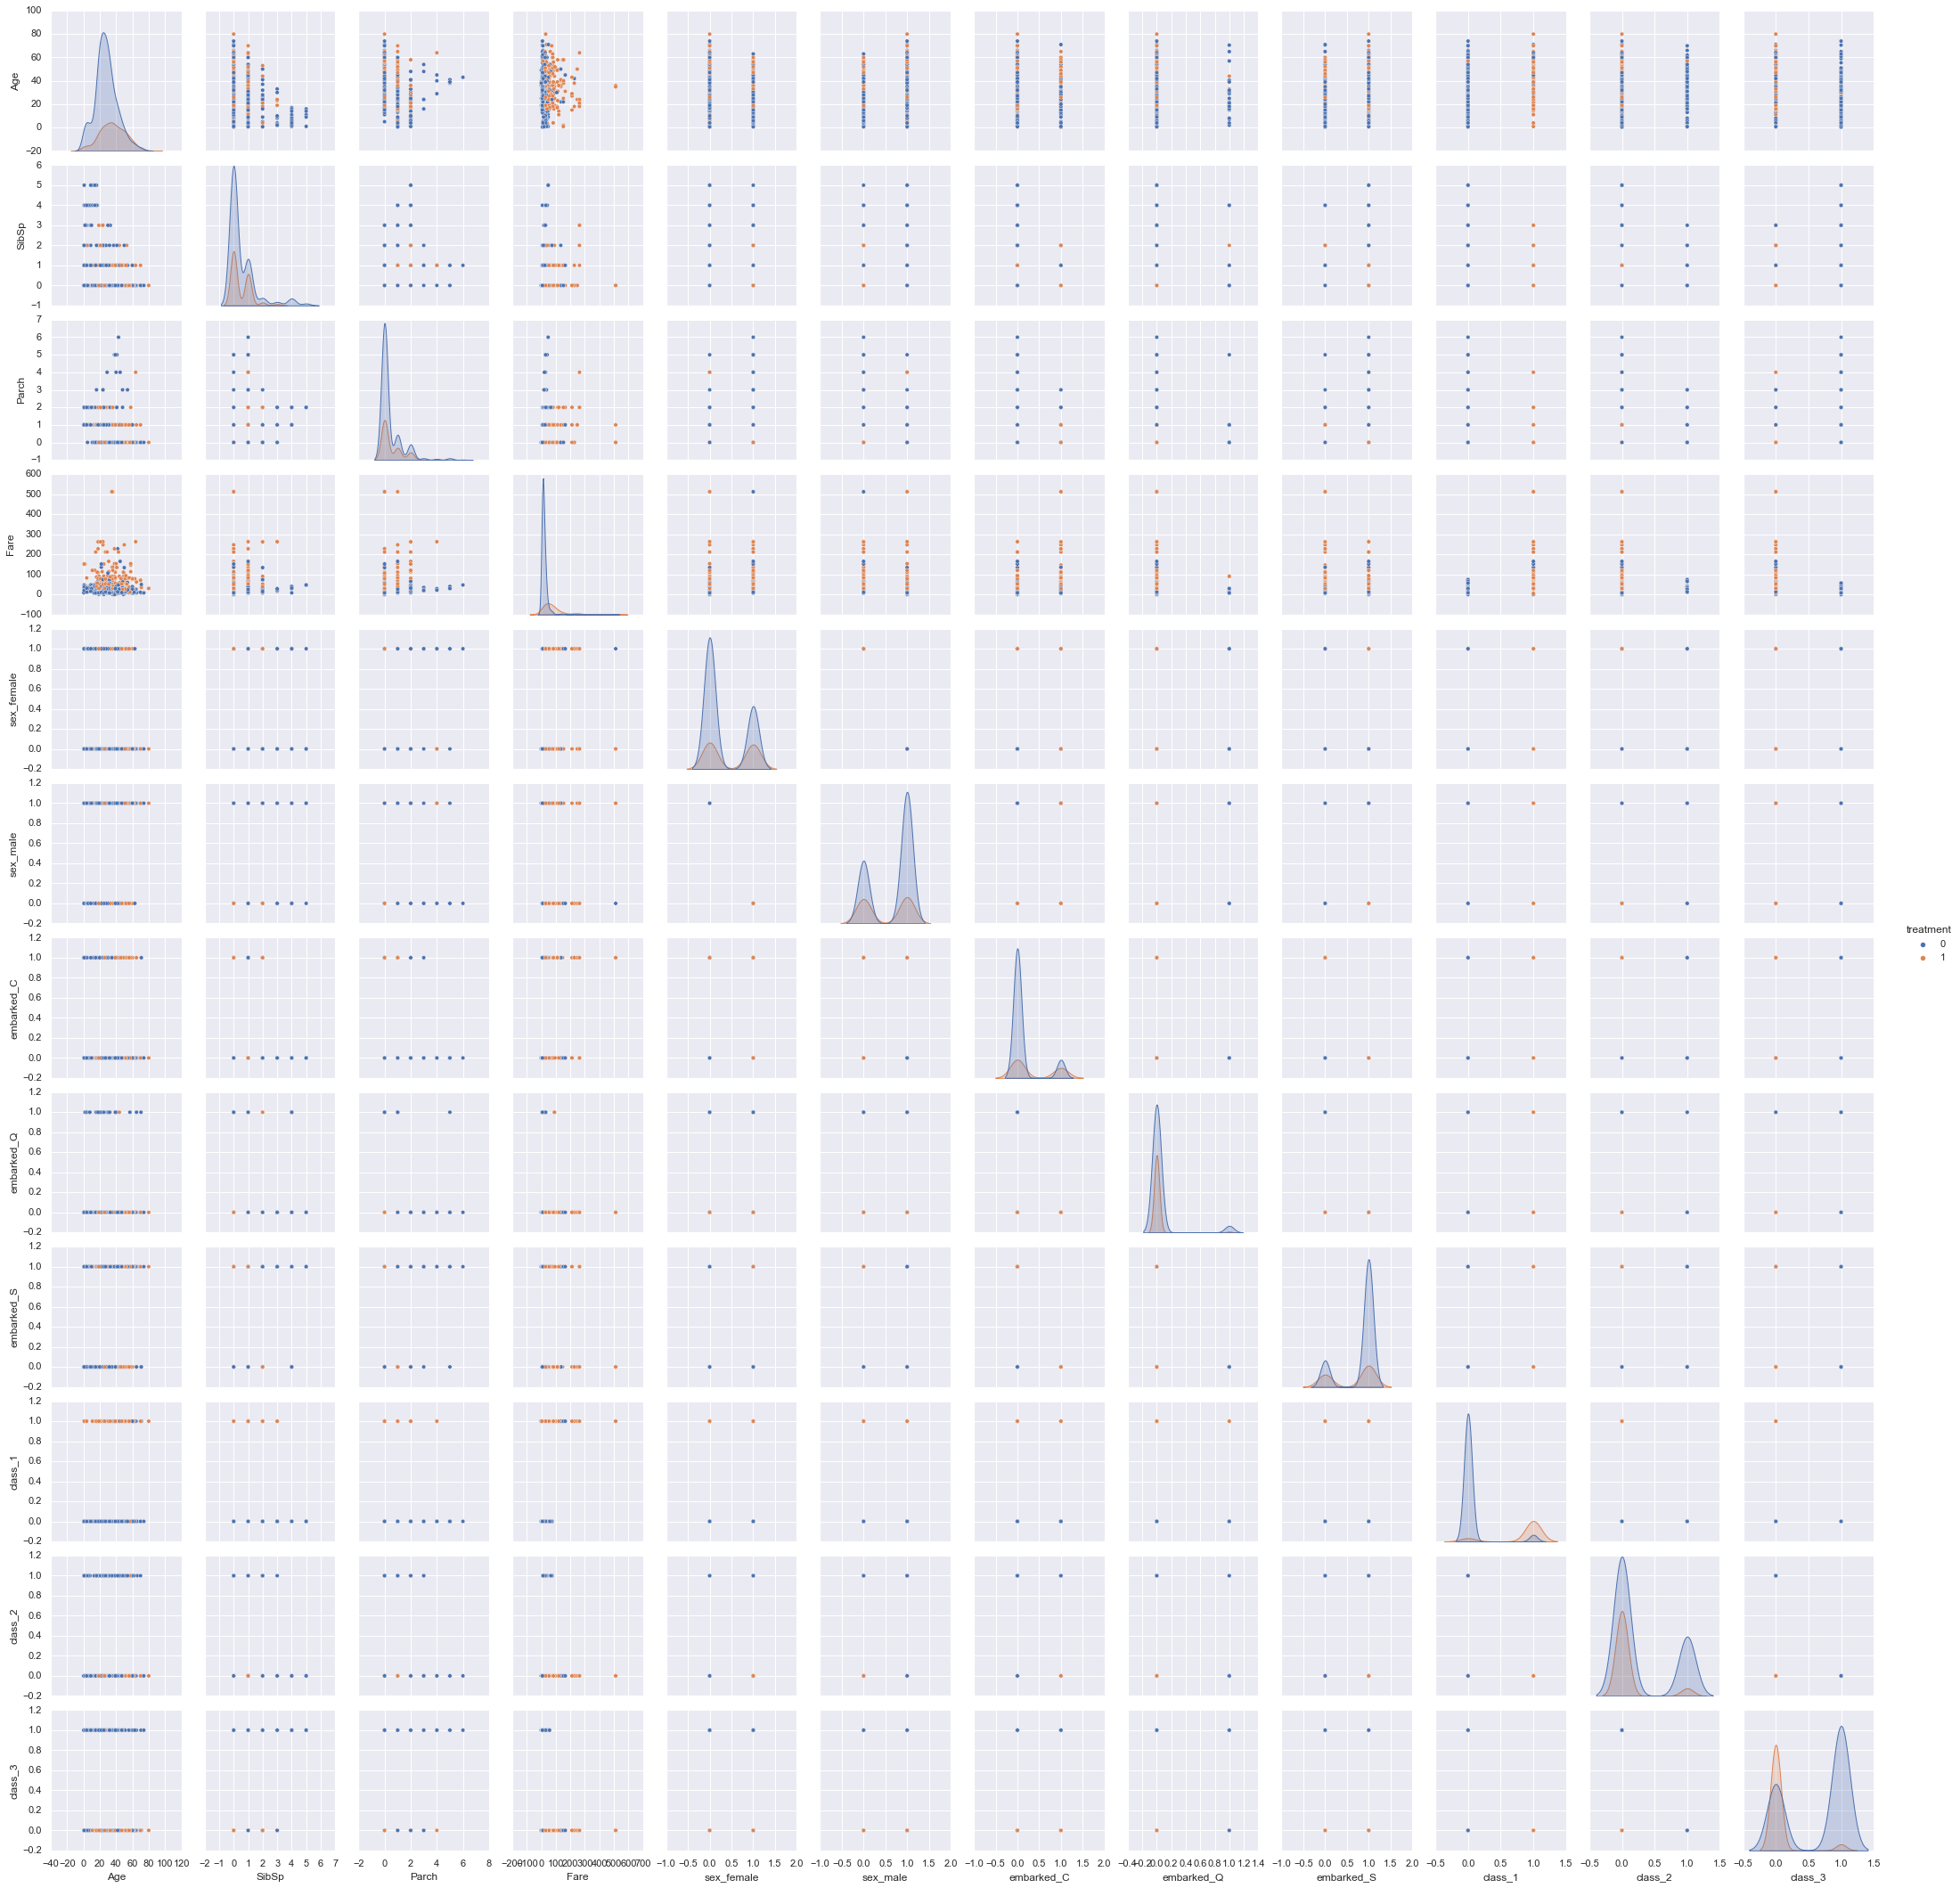

In [35]:
sns.pairplot(data = df_data[cols], hue = 'treatment')

/Users/konos/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


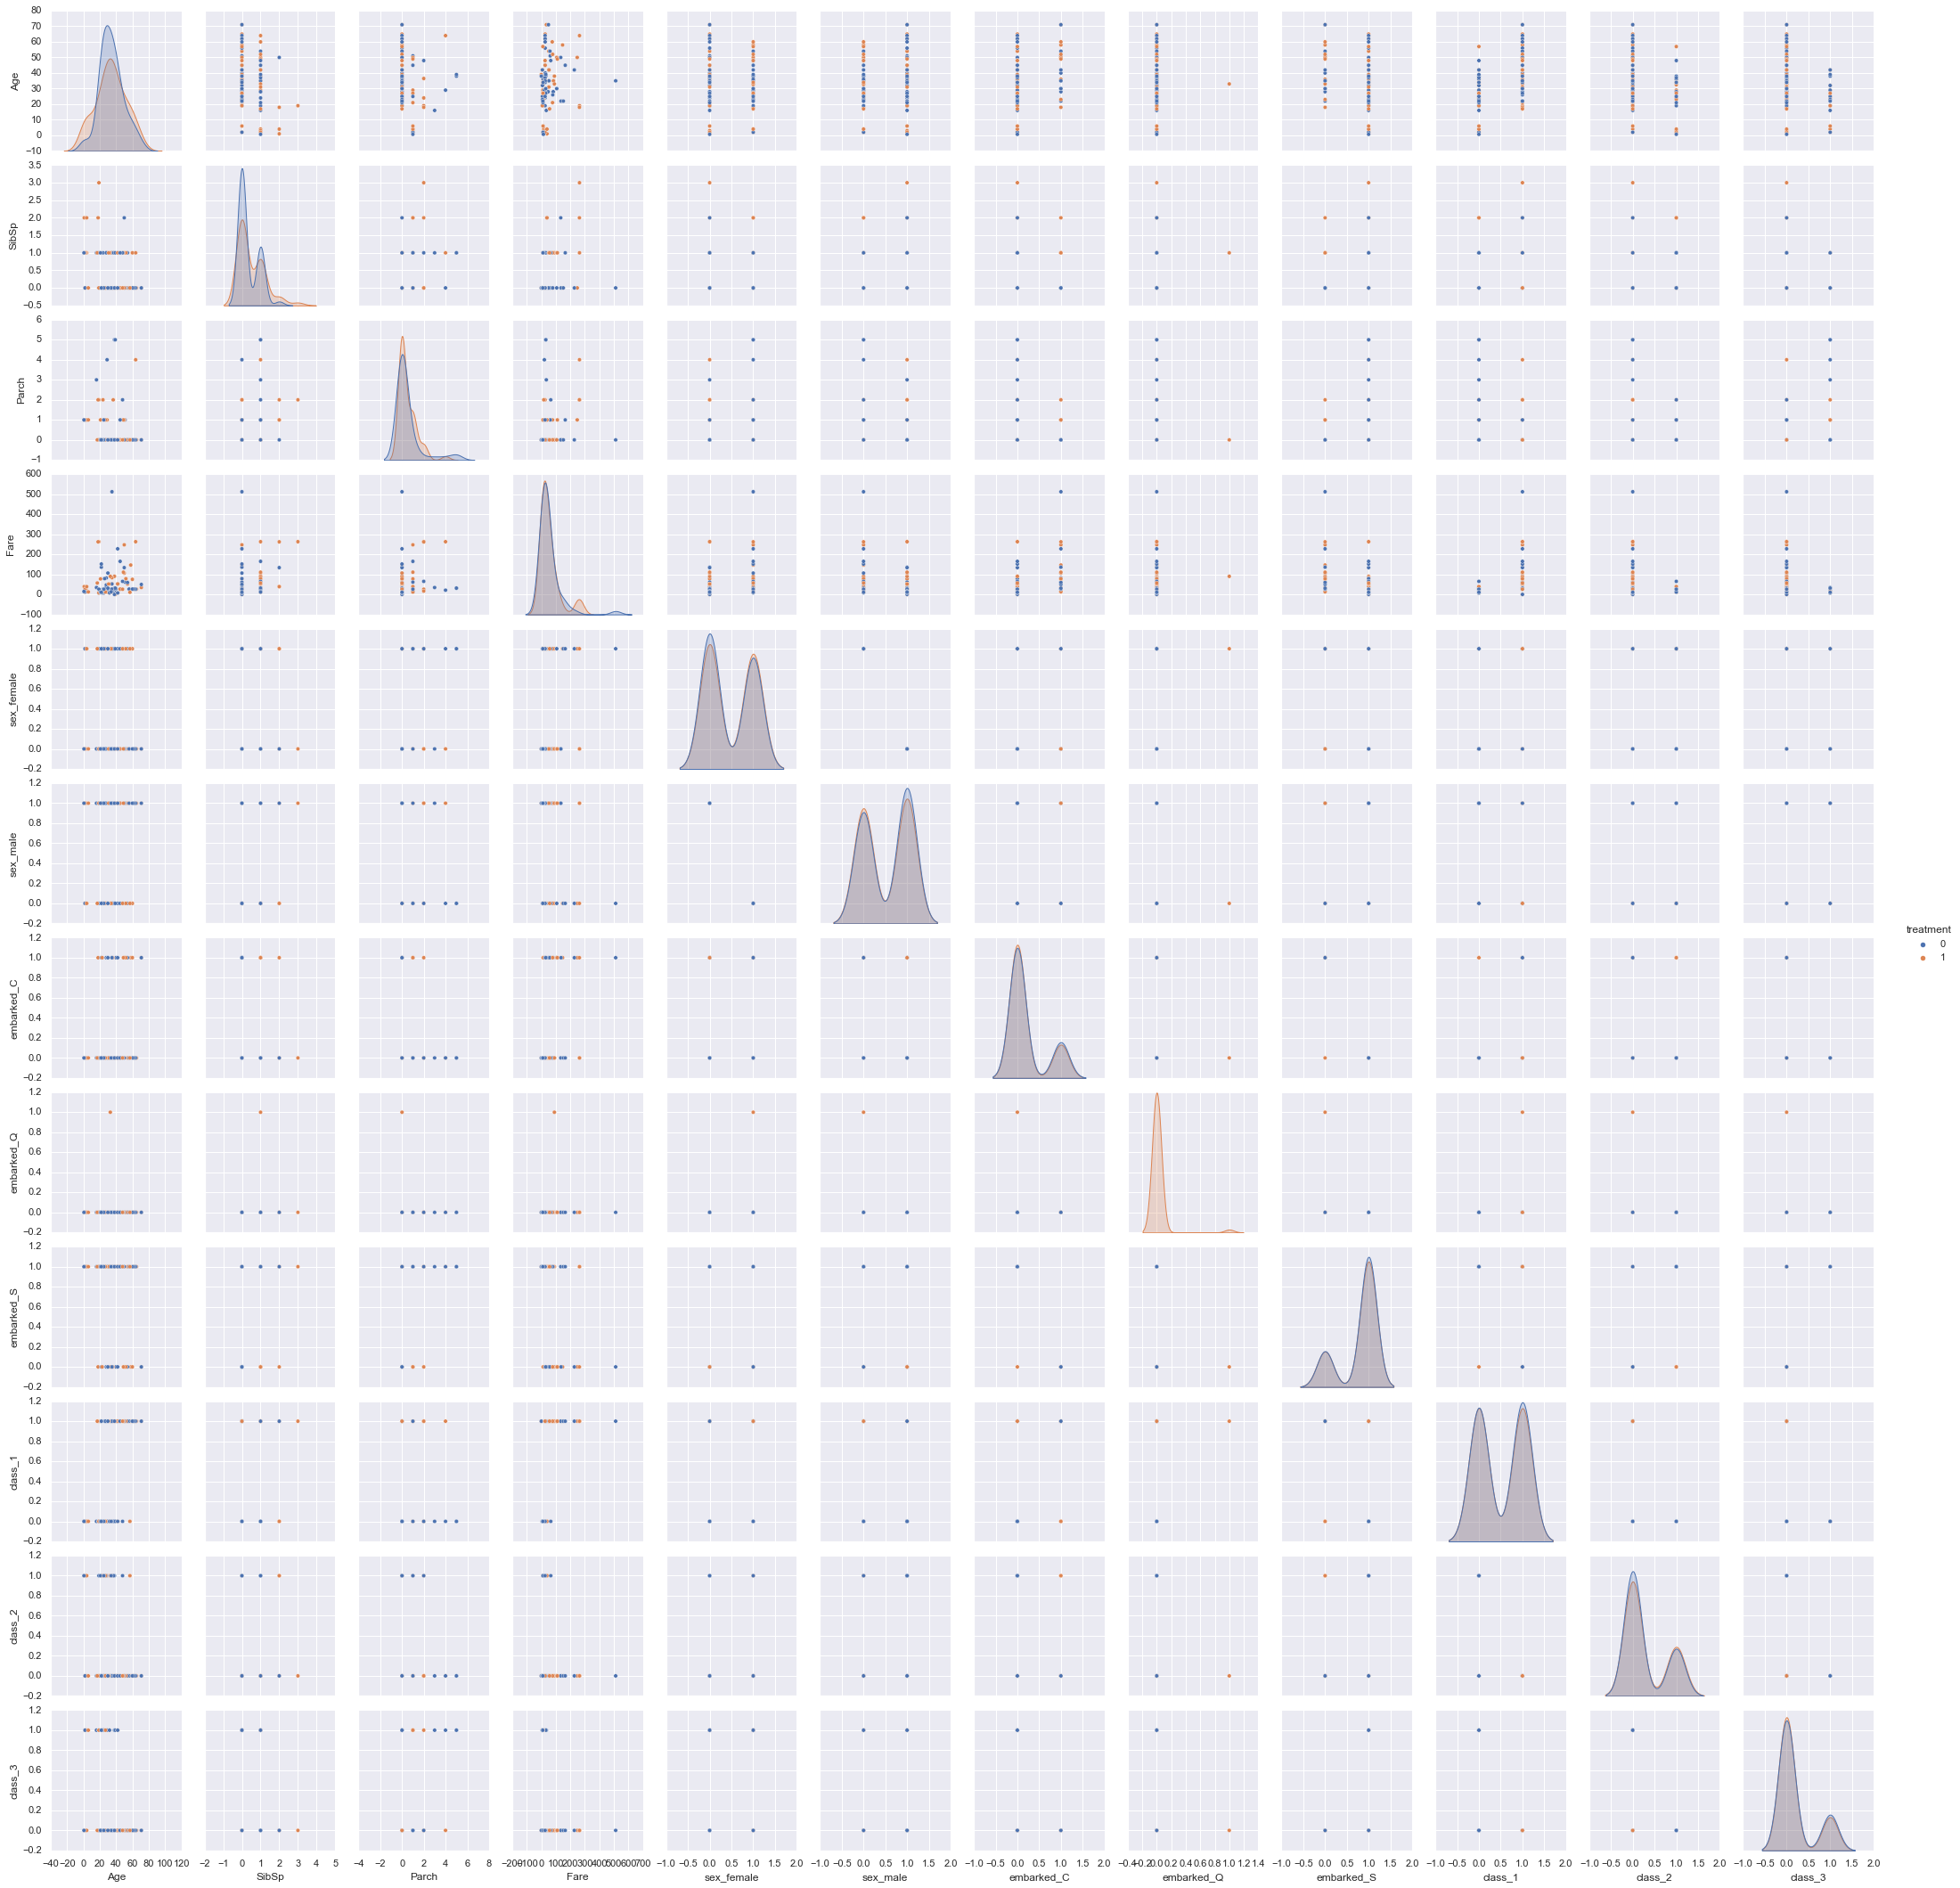

In [36]:
sns.pairplot(data = matched_data[cols], hue = 'treatment')

# Average Treatement effect

In [37]:
# TODO

# References
- Logit function definition: https://en.wikipedia.org/wiki/Logit
- Matching Methods: https://www.youtube.com/watch?v=CEikQRj5n_A
- Propensity Score Matching: https://www.youtube.com/watch?v=8KE0qj5Ef0c
- Propensity Score Matching - HelloFresh: https://www.youtube.com/watch?v=gaUgW7NWai8
- Introduction to Propensity Score Matching: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/
- https://florianwilhelm.info/2017/04/causal_inference_propensity_score/
- Cohen's d: https://en.wikipedia.org/wiki/Effect_size#Cohen's_d